In [1]:
import numpy as np
from PIL import Image
from scipy import misc
from input_matrix_generator import *
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras.optimizers import Nadam
from keras.optimizers import Adam
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras.layers import Activation
from keras.utils import np_utils
from keras import backend as K
#K.set_image_dim_ordering('th')
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
from keras.datasets import cifar10
import numpy as np
import os
from keras.datasets import cifar10
from numpy import argmax

Using TensorFlow backend.


In [2]:
def lr_schedule(epoch):
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr



In [3]:
#code adapted from cs231 stanford
def resnet_layer(inputs, num_filters=16, kernel_size=3, strides=1, activation='relu', batch_normalization=True,
conv_first=True):
    
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))
    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x



In [4]:
def resnet_block(inputs,num_filters=16,kernel_size=3,strides=1,activation='relu',batch_normalization=True,
conv_first=True):
    
    x = inputs
    if conv_first:
        x = Conv2D(num_filters,
                   kernel_size=kernel_size,
                   strides=strides,
                   padding='same',
                   kernel_initializer='he_normal',
                   kernel_regularizer=l2(1e-4))(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation:
            x = Activation(activation)(x)
        return x
    if batch_normalization:
        x = BatchNormalization()(x)
    if activation:
        x = Activation('relu')(x)
    x = Conv2D(num_filters,
               kernel_size=kernel_size,
               strides=strides,
               padding='same',
               kernel_initializer='he_normal',
               kernel_regularizer=l2(1e-4))(x)
    return x


In [5]:
def resnet_block_deconv(inputs,num_filters=16,kernel_size=3,strides=1,activation='relu',batch_normalization=True,
conv_first=True):
    
    x = inputs
    if conv_first:
        x = keras.layers.Conv2DTranspose(num_filters,kernel_size=kernel_size,strides=strides,padding='same',
                   kernel_initializer='he_normal',
                   kernel_regularizer=l2(1e-4))(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation:
            x = Activation(activation)(x)
        return x
    if batch_normalization:
        x = BatchNormalization()(x)
    if activation:
        x = Activation('relu')(x)
    x = keras.layers.Conv2DTranspose(num_filters,
               kernel_size=kernel_size,
               strides=strides,
               padding='same',
               kernel_initializer='he_normal',
               kernel_regularizer=l2(1e-4))(x)
    return x



In [6]:
def resnet(input_shape): 
    # Start model definition.
    inputs = Input(shape=input_shape)
    num_filters_in = 32
    num_filters_out = 64
    filter_multiplier = 2
    num_sub_blocks = 5

    # v2 performs Conv2D with BN-ReLU on input before splitting into 2 paths
    x = resnet_block(inputs=inputs,
                     num_filters=num_filters_in,kernel_size=3,strides=2,conv_first=True)
    # Instantiate convolutional base (stack of blocks).
    activation = None
    batch_normalization = False
    for i in range(5):
        if i ==0:
            num_filters_out = 64
        elif i==1:
            num_filters_out = 96
        elif i==2:
            num_filters_out = 128
        elif i==3:
            num_filters_out = 256
        elif i==4:
            num_filters_out=512

        for j in range(3):
            strides = 1
            is_first_layer_but_not_first_block = j == 0
            if is_first_layer_but_not_first_block:
                strides = 2
            y = resnet_block(inputs=x,
                             num_filters=num_filters_in,
                             kernel_size=1,
                             strides=strides,
                             activation=activation,
                             batch_normalization=batch_normalization,
                             conv_first=False)
            activation = 'relu'
            batch_normalization = True
            y = resnet_block(inputs=y,
                             num_filters=num_filters_in,
                             conv_first=False)
            y = resnet_block(inputs=y,
                             num_filters=num_filters_out,
                             kernel_size=1,
                             conv_first=False)
            if j == 0:
                x = resnet_block(inputs=x,
                                 num_filters=num_filters_out,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])
        if i ==0:
            num_filters_in = 64
        elif i==1:
            num_filters_in = 96
        elif i==2:
            num_filters_in = 128
        elif i==3:
            num_filters_in = 256
        elif i==4:
            num_filters_in=512


 

    # Add classifier on top.
    # v2 has BN-ReLU before Pooling
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    
    num_filters_in=512
    filter_divider=2
    
    for i in range(5):
        if i ==0:
            num_filters_out = 512
        elif i==1:
            num_filters_out = 256
        elif i==2:
            num_filters_out = 128
        elif i==3:
            num_filters_out = 96
        elif i==4:
            num_filters_out=64
        for j in range(3):
            strides = 1
            is_first_layer_but_not_first_block = j == 0
            if is_first_layer_but_not_first_block:
                strides = 2
            if is_first_layer_but_not_first_block:
                y = resnet_block_deconv(inputs=x,
                                 num_filters=num_filters_in,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=activation,
                                 batch_normalization=batch_normalization,
                                 conv_first=False)
            else:
                y = resnet_block(inputs=x,
                                 num_filters=num_filters_in,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=activation,
                                 batch_normalization=batch_normalization,
                                 conv_first=False)
            activation = 'relu'
            batch_normalization = True
            y = resnet_block(inputs=y,
                             num_filters=num_filters_in,
                             conv_first=False)
            y = resnet_block(inputs=y,
                             num_filters=num_filters_out,
                             kernel_size=1,
                             conv_first=False)
            if j == 0:
                x = resnet_block_deconv(inputs=x,
                                 num_filters=num_filters_out,
                                 kernel_size=2,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])
        if i ==0:
            num_filters_in = 512
        elif i==1:
            num_filters_in = 256
        elif i==2:
            num_filters_in = 128
        elif i==3:
            num_filters_in = 96
        elif i==4:
            num_filters_in=64
    # Add classifier on top.
    # v2 has BN-ReLU before Pooling
    #x = BatchNormalization()(x)
    #x = Activation('relu')(x)
    x = resnet_block(inputs=x,num_filters=1,kernel_size=1,strides = 4,conv_first=False)
    x=Flatten()(x)
    outputs = Dense(1000,kernel_constraint=maxnorm(3))(x)
    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model


In [7]:
model = resnet(input_shape=[1000,1000,1])

0


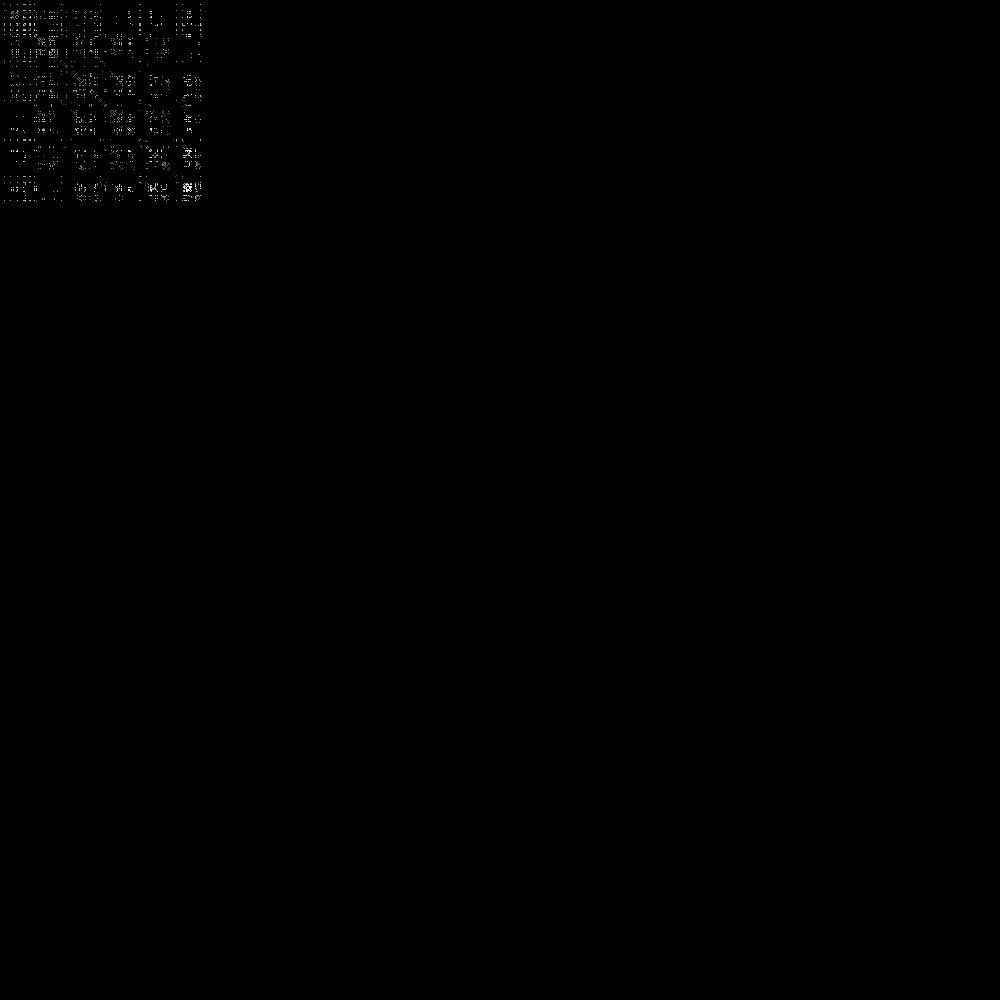

0


/home/seifhelal/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: ./img/0.png is a low contrast image
  warn('%s is a low contrast image' % fname)


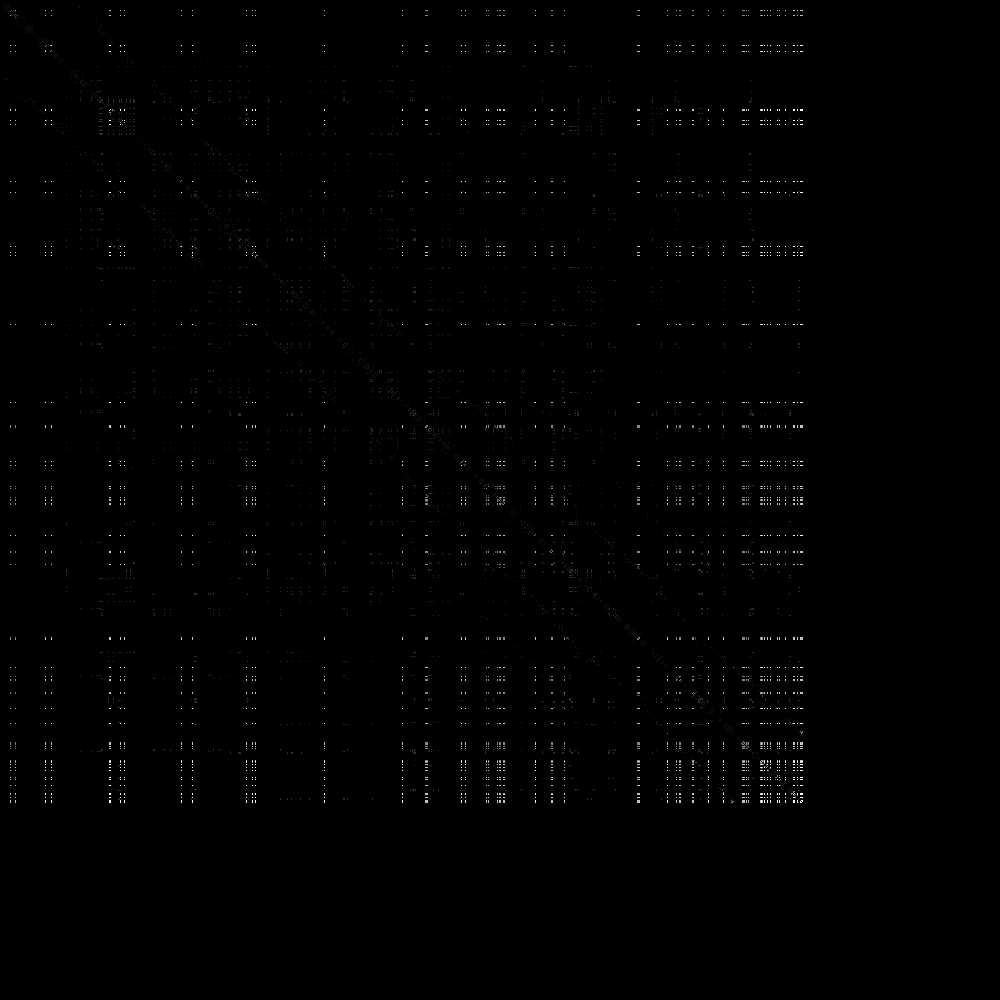

0


/home/seifhelal/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: ./img/1.png is a low contrast image
  warn('%s is a low contrast image' % fname)


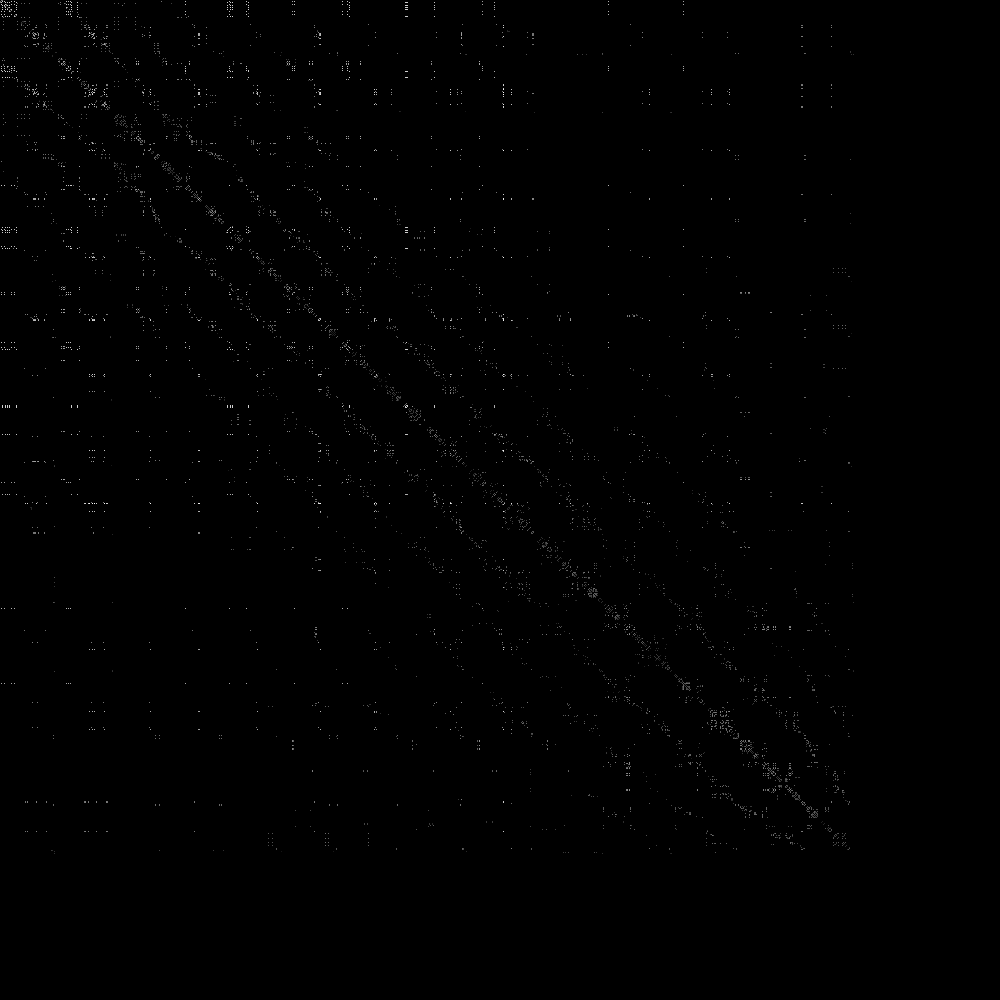

0


/home/seifhelal/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: ./img/2.png is a low contrast image
  warn('%s is a low contrast image' % fname)


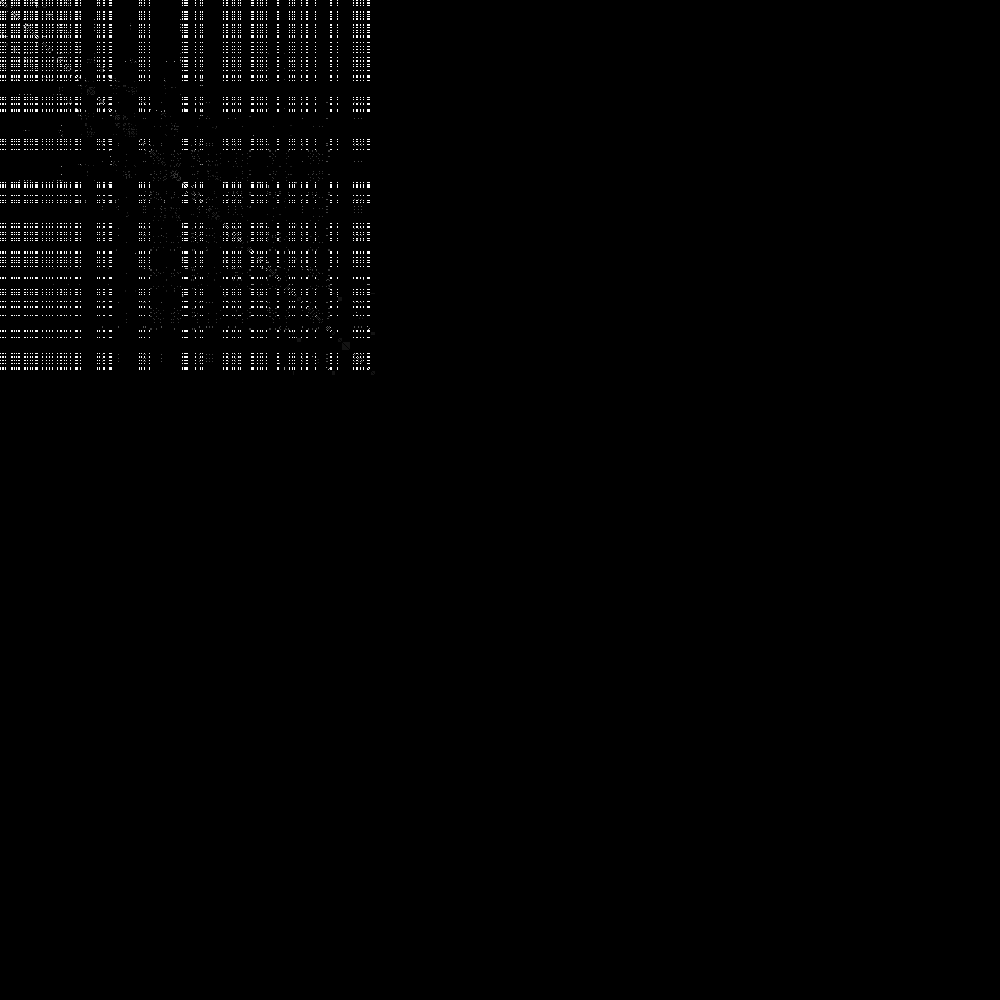

0


/home/seifhelal/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: ./img/3.png is a low contrast image
  warn('%s is a low contrast image' % fname)


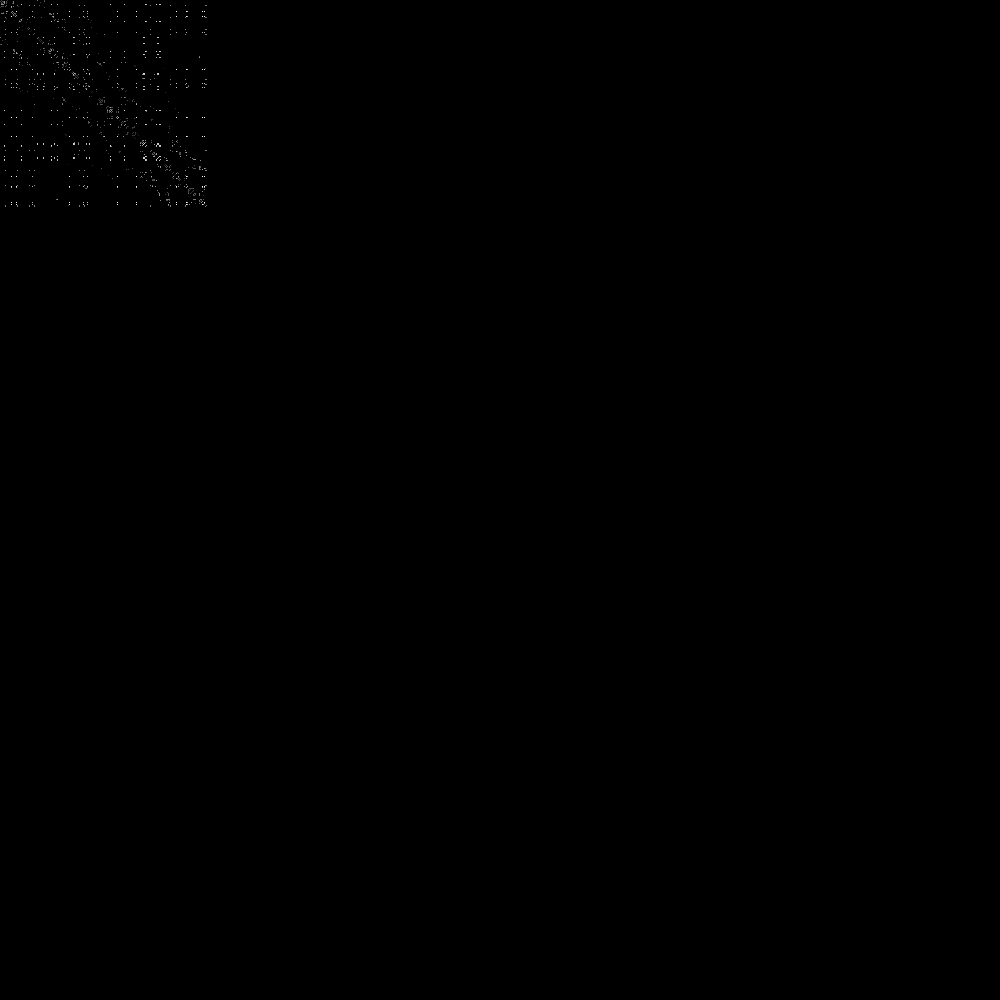

0


/home/seifhelal/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: ./img/4.png is a low contrast image
  warn('%s is a low contrast image' % fname)


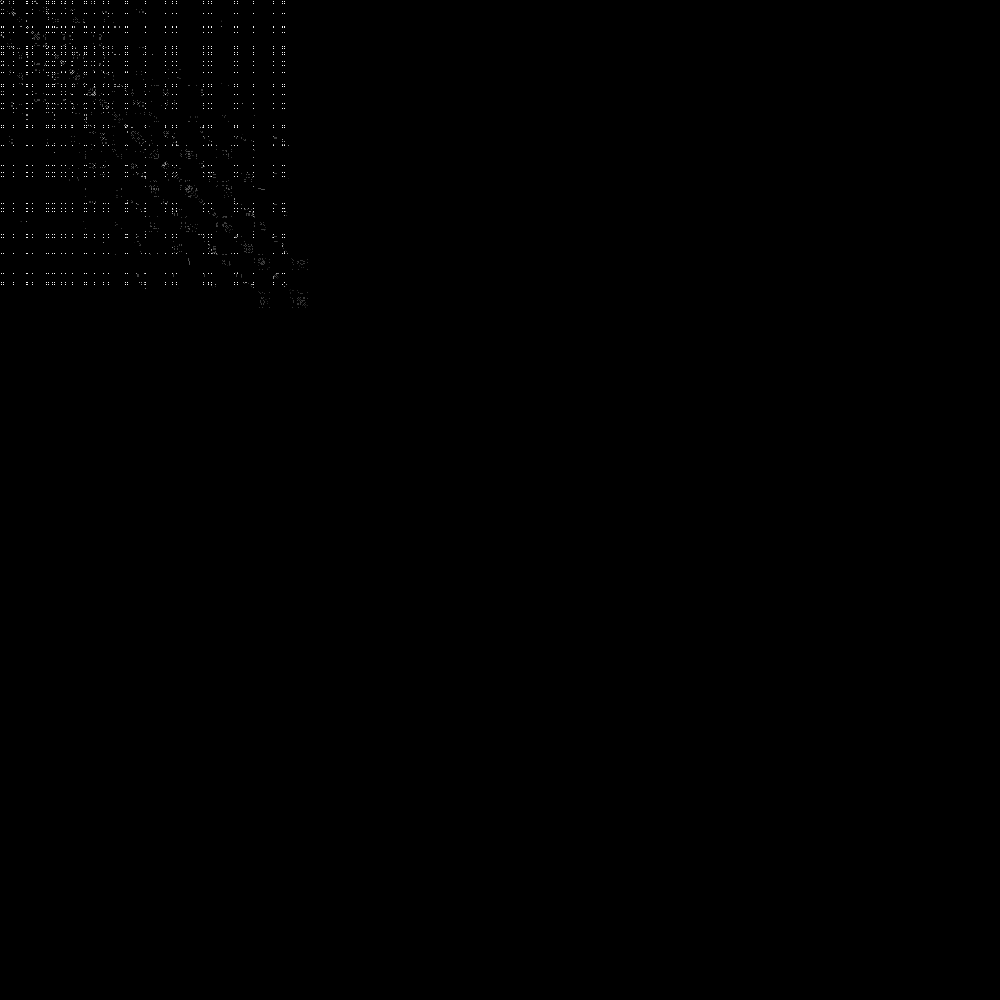

0


/home/seifhelal/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: ./img/5.png is a low contrast image
  warn('%s is a low contrast image' % fname)


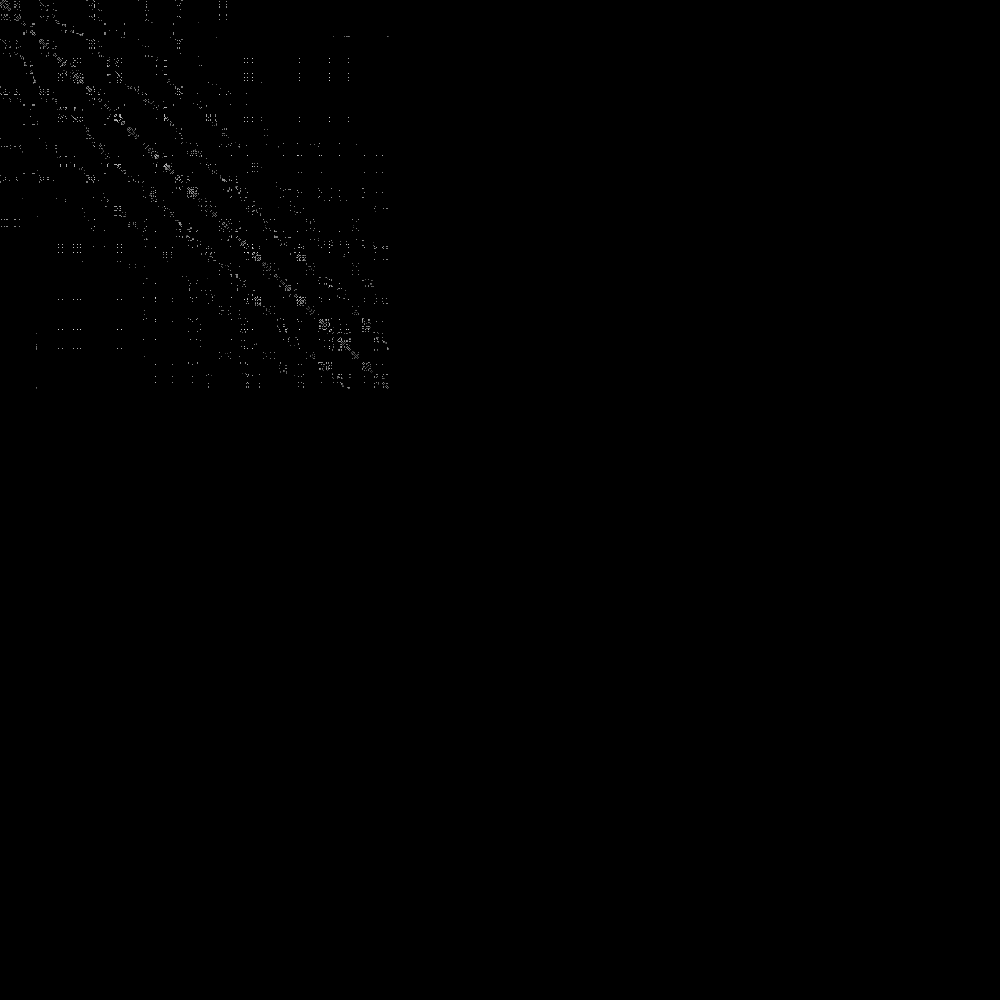

/home/seifhelal/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: ./img/6.png is a low contrast image
  warn('%s is a low contrast image' % fname)


0


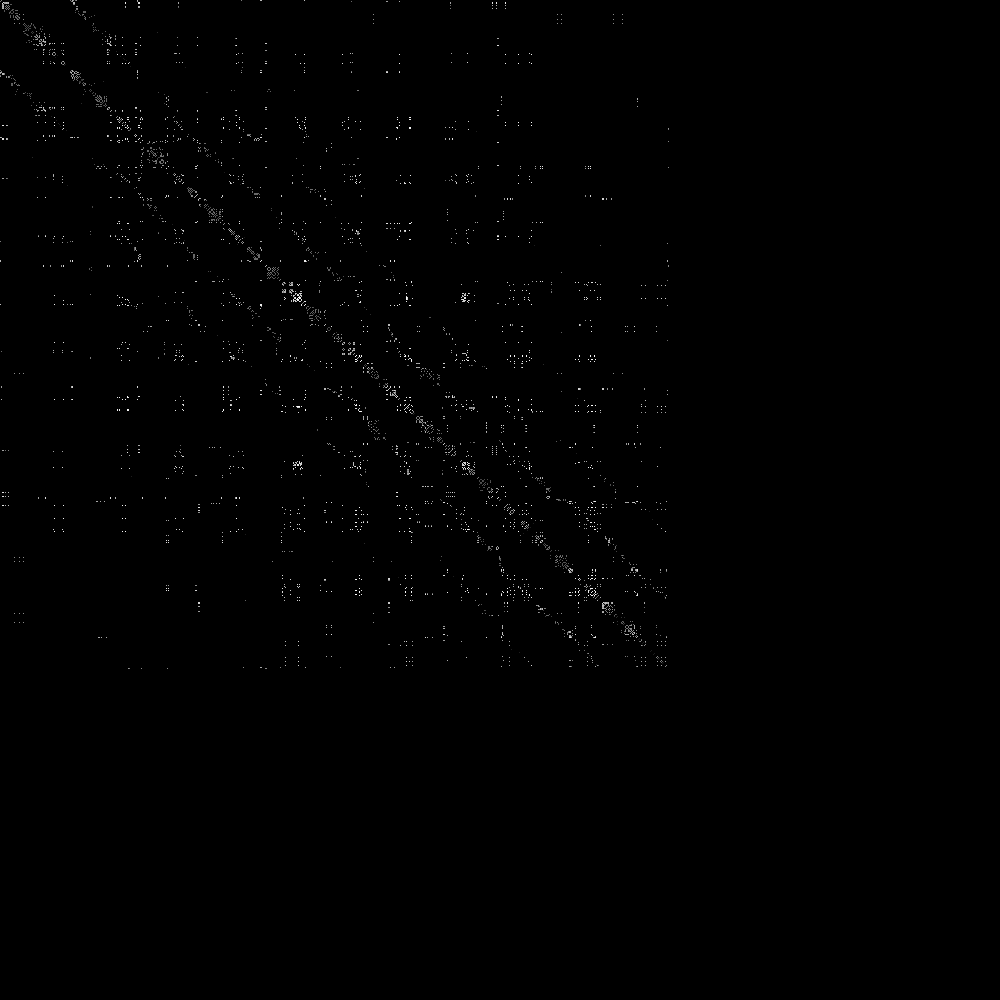

/home/seifhelal/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: ./img/7.png is a low contrast image
  warn('%s is a low contrast image' % fname)


0


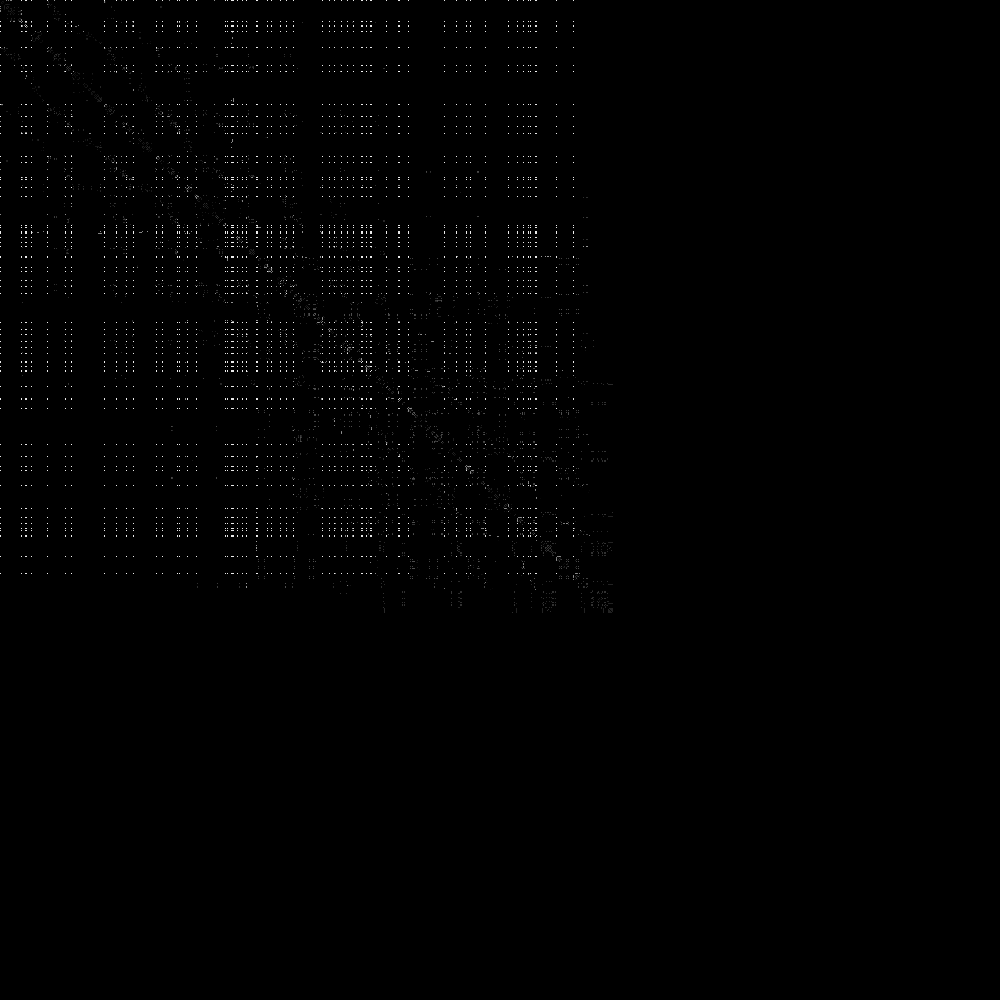

/home/seifhelal/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: ./img/8.png is a low contrast image
  warn('%s is a low contrast image' % fname)


0


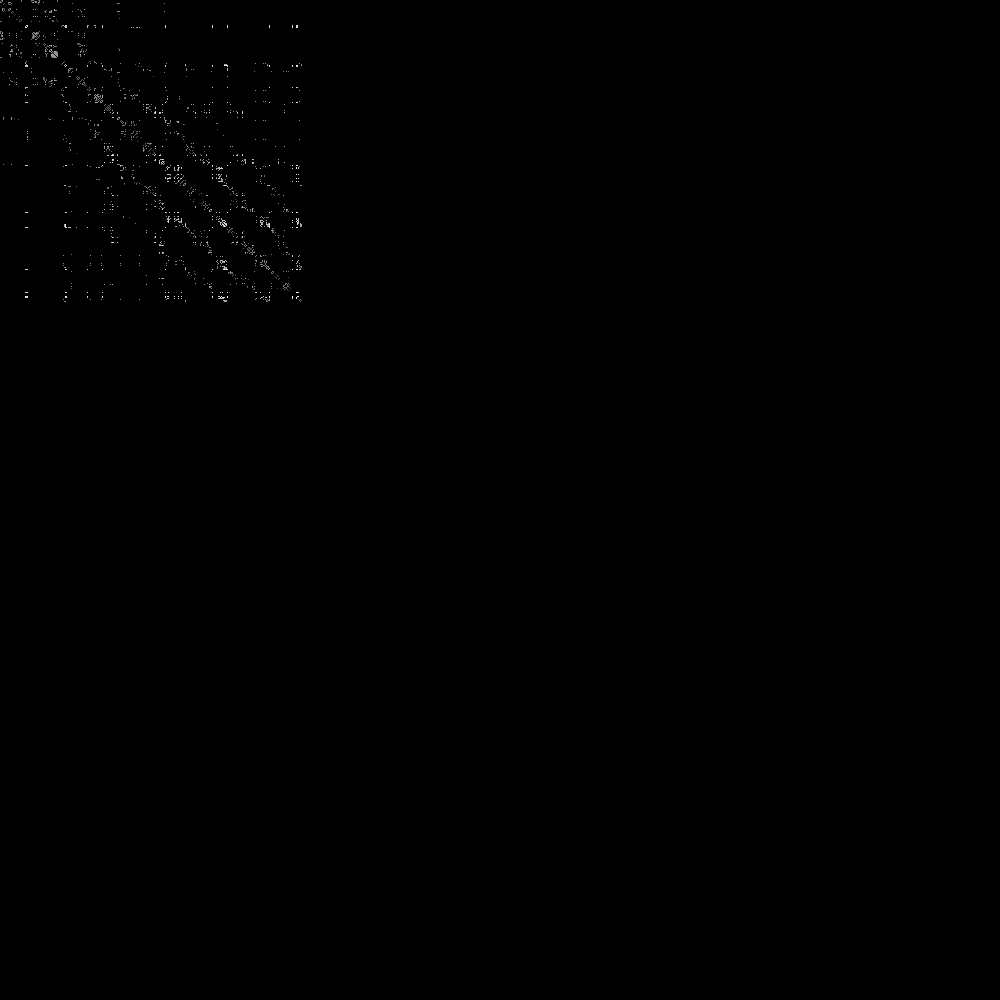

/home/seifhelal/anaconda3/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: ./img/9.png is a low contrast image
  warn('%s is a low contrast image' % fname)


In [8]:
X,Y_x,Y_y,sizes=dataset([1000,10000,100000,300000])
X_train_o=X[:8]
X_test_o=X[8:]
Y_train=Y_x[:8]
Y_test=Y_x[8:]

In [9]:
print(X_train_o.shape)
print(X_test_o.shape)
print(Y_train.shape)
print(Y_test.shape)
size = 1000, 1000
X_train = np.empty((8,1000,1000))
X_test = np.empty((2,1000, 1000))
X_train_new= ()
for i in range (X_train.shape[0]):
    img = misc.imresize(X_train_o[i], size)
    X_train[i] = misc.imresize(img, size)
for j in range (2):
    img = misc.imresize(X_test_o[j], size)
    X_test[j] = misc.imresize(img, size)
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],X_train.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],X_test.shape[2], 1)
print(X_train.shape)
print(X_test.shape)
X_train = X_train.astype('float16')
X_test = X_test.astype('float16')

/home/seifhelal/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  # Remove the CWD from sys.path while we load stuff.
/home/seifhelal/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  # This is added back by InteractiveShellApp.init_path()


(8, 1000, 1000)
(2, 1000, 1000)
(8, 1000)
(2, 1000)


/home/seifhelal/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  del sys.path[0]


(8, 1000, 1000, 1)
(2, 1000, 1000, 1)


/home/seifhelal/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


In [10]:
#loading orignal images in matrix array
matrix=[]
path='dataset2'
for file in os.listdir(path):
        matrix.append(smp.imread(os.path.join(path, file)))
matrix=np.array(matrix[:8])

/home/seifhelal/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """


In [11]:
def custom_objective(ground_truth_placement, predicted_placement):
    total_loss=np.absolute(predicted_placement - ground_truth_placement)
    total_loss= K.sum(total_loss, axis = 0)
    x= (total_loss)/(1000)
    print ("sizeee \n")
    print (ground_truth_placement.shape)
    return (x) 

In [12]:
#y_train = np_utils.to_categorical(y_train)
#y_test = np_utils.to_categorical(y_test)
num_classes = len(Y_test[0])
print (num_classes)

1000


In [13]:
def custom2_objective(adj_matrix, predicted_placement):
    optimal_wire_length = 0
    total_wire_length_xy=0
    looper= 300
    for i in range(0, int(looper)):
        for j in range(i+1, int (looper)):
            if adj_matrix[i][j] != 0.0:
                total_wire_length_xy += np.absolute(predicted_placement[i] - predicted_placement[j])
    wire_loss= (total_wire_length_xy - optimal_wire_length) / adj_matrix.shape[0]
    return wire_loss

In [14]:
def wirrre_length_loss(adj_matrix, predicted_placement):
    optimal_wire_length = 0
    total_wire_length_xy=0
    #total_wire_length = np.empty((adj_matrix.shape[0], adj_matrix.shape[1]))
    #print(total_wire_length.shape)
    #print(adj_matrix.shape)
    for k in range(adj_matrix.shape[0]):
        for i in range(0, adj_matrix.shape[1]):
            for j in range(i+1, adj_matrix.shape[1]):
                if adj_matrix[k][i][j] != 0.0:
                    #print(predicted_placement[k][i])
                    total_wire_length_xy += np.absolute(predicted_placement[k][i] - predicted_placement[k][j])
        print(total_wire_length_xy.shape)
        #total_wire_length[k] = total_wire_length_xy[0] + total_wire_length_xy[1]
    wire_loss= (total_wire_length_xy - optimal_wire_length) / adj_matrix.shape[1]
    return wire_loss

In [15]:
def wire_loss_func(adj_matrix):
    def loss_func(optimal_wire_length, predicted_placement):
        return wire_length_loss(predicted_placement, adj_matrix, optimal_wire_length = optimal_wire_length)
    return loss_func

In [16]:
def custom_metric(y_true, y_pred):
    #acc = 100 - ((y_pred - y_true / y_true)*100)
    #return 100 - (K.mean()/y_true)*100
    #return (K.sum(y_true) / K.sum(y_pred*100))
    return (K.mean(y_pred)*500)


In [17]:
epochs = 200
lrate = 1e-2
decay = lrate/epochs
nadam = Adam(lr=lrate,beta_1=0.9, beta_2 = 0.999, epsilon = 1e-8,decay=decay)
model.compile(loss=custom_objective, optimizer=nadam)
print(model.summary())

sizeee 

(?, ?)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1000, 1000, 1 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 500, 500, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 500, 500, 32) 128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 500, 500, 32) 0           batch_normalization_1[0][0]      
_____________________________________________________________________________________________

In [18]:
datagen = ImageDataGenerator()


In [19]:
datagen.fit(X_train)
print (X_train.shape)
checkpointer = ModelCheckpoint(filepath="./model_digital.hdf5", verbose=1, save_best_only=True, monitor='val_acc')

# Fit the model on the batches generated by datagen.flow().
model.fit_generator(datagen.flow(X_train, Y_train, batch_size=1),
                        epochs=150,
                        validation_data=(X_test, Y_test),
                        workers=1, 
                        callbacks=[checkpointer])


(8, 1000, 1000, 1)
Epoch 1/150
8/8 [==============================] - 15s 2s/step - loss: 9.2692 - val_loss: 9.9483
Epoch 2/150


/home/seifhelal/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:435: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


8/8 [==============================] - 4s 560ms/step - loss: 7.7546 - val_loss: 165.0939
Epoch 3/150
8/8 [==============================] - 5s 579ms/step - loss: 7.0425 - val_loss: 2788.9483
Epoch 4/150
8/8 [==============================] - 5s 573ms/step - loss: 7.4815 - val_loss: 240.8942
Epoch 5/150
8/8 [==============================] - 5s 571ms/step - loss: 7.0663 - val_loss: 30.3525
Epoch 6/150
8/8 [==============================] - 5s 569ms/step - loss: 6.8866 - val_loss: 14.0671
Epoch 7/150
8/8 [==============================] - 5s 582ms/step - loss: 6.4466 - val_loss: 15.9499
Epoch 8/150
8/8 [==============================] - 5s 576ms/step - loss: 6.5543 - val_loss: 21.5219
Epoch 9/150
8/8 [==============================] - 5s 569ms/step - loss: 6.0874 - val_loss: 25.0677
Epoch 10/150
8/8 [==============================] - 4s 562ms/step - loss: 6.2354 - val_loss: 22.8587
Epoch 11/150
8/8 [==============================] - 5s 568ms/step - loss: 5.8888 - val_loss: 190.2337
Epoch

8/8 [==============================] - 5s 586ms/step - loss: 3.9087 - val_loss: 8.7421
Epoch 84/150
8/8 [==============================] - 5s 588ms/step - loss: 3.8731 - val_loss: 8.8777
Epoch 85/150
8/8 [==============================] - 5s 580ms/step - loss: 4.0931 - val_loss: 8.8183
Epoch 86/150
8/8 [==============================] - 5s 584ms/step - loss: 3.7897 - val_loss: 8.7971
Epoch 87/150
8/8 [==============================] - 5s 582ms/step - loss: 3.8384 - val_loss: 8.9876
Epoch 88/150
8/8 [==============================] - 5s 592ms/step - loss: 3.8391 - val_loss: 8.7594
Epoch 89/150
8/8 [==============================] - 5s 576ms/step - loss: 3.5578 - val_loss: 8.9057
Epoch 90/150
8/8 [==============================] - 5s 579ms/step - loss: 3.8486 - val_loss: 8.7618
Epoch 91/150
8/8 [==============================] - 5s 594ms/step - loss: 4.1156 - val_loss: 8.9284
Epoch 92/150
8/8 [==============================] - 5s 584ms/step - loss: 3.9293 - val_loss: 8.9156
Epoch 93/150


In [20]:
testing_predictionn = model.predict(X_train)


In [29]:
for i in range (len(testing_predictionn[0])):
    print ("prediction for cell %d is %d"%(i, testing_predictionn[0][i]))
    print ("ground truth for cell %d is %d" %(i, int(Y_train[0][i])))

prediction for cell 0 is -801
ground truth for cell 0 is 80
prediction for cell 1 is 3793
ground truth for cell 1 is 3600
prediction for cell 2 is 3463
ground truth for cell 2 is 4080
prediction for cell 3 is 2698
ground truth for cell 3 is 4720
prediction for cell 4 is 4276
ground truth for cell 4 is 5200
prediction for cell 5 is 3039
ground truth for cell 5 is 6000
prediction for cell 6 is 4039
ground truth for cell 6 is 6320
prediction for cell 7 is 3975
ground truth for cell 7 is 6960
prediction for cell 8 is 7684
ground truth for cell 8 is 7440
prediction for cell 9 is 7107
ground truth for cell 9 is 7760
prediction for cell 10 is 5924
ground truth for cell 10 is 8080
prediction for cell 11 is 7673
ground truth for cell 11 is 8560
prediction for cell 12 is 6414
ground truth for cell 12 is 9360
prediction for cell 13 is 5941
ground truth for cell 13 is 9680
prediction for cell 14 is 9953
ground truth for cell 14 is 10160
prediction for cell 15 is 9787
ground truth for cell 15 is 10

In [30]:
for i in range (len(testing_predictionn[1])):
    print ("prediction for cell %d is %d"%(i, testing_predictionn[1][i]))
    print ("ground truth for cell %d is %d" %(i, int(Y_train[1][i])))

prediction for cell 0 is -926
ground truth for cell 0 is 80
prediction for cell 1 is 3844
ground truth for cell 1 is 560
prediction for cell 2 is 3556
ground truth for cell 2 is 4080
prediction for cell 3 is 2845
ground truth for cell 3 is 4560
prediction for cell 4 is 4387
ground truth for cell 4 is 8080
prediction for cell 5 is 3144
ground truth for cell 5 is 8240
prediction for cell 6 is 4147
ground truth for cell 6 is 8400
prediction for cell 7 is 4159
ground truth for cell 7 is 8560
prediction for cell 8 is 7722
ground truth for cell 8 is 9040
prediction for cell 9 is 7164
ground truth for cell 9 is 9520
prediction for cell 10 is 6000
ground truth for cell 10 is 10160
prediction for cell 11 is 7920
ground truth for cell 11 is 10640
prediction for cell 12 is 6660
ground truth for cell 12 is 11120
prediction for cell 13 is 6200
ground truth for cell 13 is 11760
prediction for cell 14 is 10198
ground truth for cell 14 is 15280
prediction for cell 15 is 9931
ground truth for cell 15 i

In [31]:
for i in range (len(testing_predictionn[4])):
    print ("prediction for cell %d is %d"%(i, testing_predictionn[4][i]))
    print ("ground truth for cell %d is %d" %(i, int(Y_train[4][i])))

prediction for cell 0 is -1277
ground truth for cell 0 is 80
prediction for cell 1 is 3891
ground truth for cell 1 is 560
prediction for cell 2 is 3510
ground truth for cell 2 is 1040
prediction for cell 3 is 2493
ground truth for cell 3 is 1520
prediction for cell 4 is 3824
ground truth for cell 4 is 2000
prediction for cell 5 is 2783
ground truth for cell 5 is 3920
prediction for cell 6 is 4179
ground truth for cell 6 is 4400
prediction for cell 7 is 4138
ground truth for cell 7 is 4880
prediction for cell 8 is 7530
ground truth for cell 8 is 5040
prediction for cell 9 is 7089
ground truth for cell 9 is 5200
prediction for cell 10 is 5920
ground truth for cell 10 is 5360
prediction for cell 11 is 7760
ground truth for cell 11 is 7280
prediction for cell 12 is 6474
ground truth for cell 12 is 7920
prediction for cell 13 is 6062
ground truth for cell 13 is 8240
prediction for cell 14 is 10191
ground truth for cell 14 is 8880
prediction for cell 15 is 9778
ground truth for cell 15 is 92